In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
import re
from gensim import corpora
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import warnings
warnings.filterwarnings("ignore")

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

%matplotlib inline

In [2]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [3]:
feature_df.dropna(inplace = True)

In [4]:
feature_df = feature_df.sample(n=5000)

In [5]:
feature_df.sentiment.value_counts()

Poor       1685
Neutral    1661
Good       1654
Name: sentiment, dtype: int64

In [6]:
feature_df.head(1)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
16924,Neutral,grab fry way,0.037037,0.0681,0.333333


In [7]:
y = feature_df["sentiment"]

In [8]:
y

16924     Neutral
211921       Poor
15007     Neutral
173774       Poor
144408       Good
           ...   
121857       Good
37235     Neutral
161024       Poor
225052       Poor
37316     Neutral
Name: sentiment, Length: 5000, dtype: object

In [9]:
x = feature_df.drop(columns = ["sentiment"])

In [10]:
x.head(1)

,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
16924,grab fry way,0.037037,0.0681,0.333333


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [12]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 4)
y_train shape: (4000,)

x_test shape: (1000, 4)
y_test shape: (1000,)



In [13]:
#Count Vectors as features

In [14]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [15]:
#create df for the vectors (both train and test)

In [16]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [17]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [18]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [19]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [20]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9136    0.8488    0.8800       324
     Neutral     0.7728    0.9099    0.8358       344
        Good     0.8435    0.7470    0.7923       332

    accuracy                         0.8360      1000
   macro avg     0.8433    0.8352    0.8360      1000
weighted avg     0.8419    0.8360    0.8357      1000

RF
              precision    recall  f1-score   support

        Poor     0.9359    0.8117    0.8694       324
     Neutral     0.7700    0.8953    0.8280       344
        Good     0.8088    0.7771    0.7926       332

    accuracy                         0.8290      1000
   macro avg     0.8382    0.8281    0.8300      1000
weighted avg     0.8366    0.8290    0.8297      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9598    0.7377    0.8342       324
     Neutral     0.7827    0.8692    0.8237       344
        Good     0.7344    0.8163    0.7732       332

    ac

In [21]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,3.368988,0.126489,0.82625,0.826441,LogReg
1,3.716146,0.123208,0.83875,0.839683,LogReg
2,3.203365,0.141957,0.83000,0.829816,LogReg
3,3.565145,0.128934,0.82875,0.828435,LogReg
4,3.472014,0.132718,0.82250,0.822672,LogReg
5,10.062288,0.234437,0.80625,0.806568,RF
6,10.657050,0.197422,0.80750,0.808025,RF
7,10.315265,0.162649,0.82000,0.818952,RF
8,10.402198,0.182276,0.81625,0.816730,RF
9,10.135189,0.189672,0.81375,0.814953,RF


In [22]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

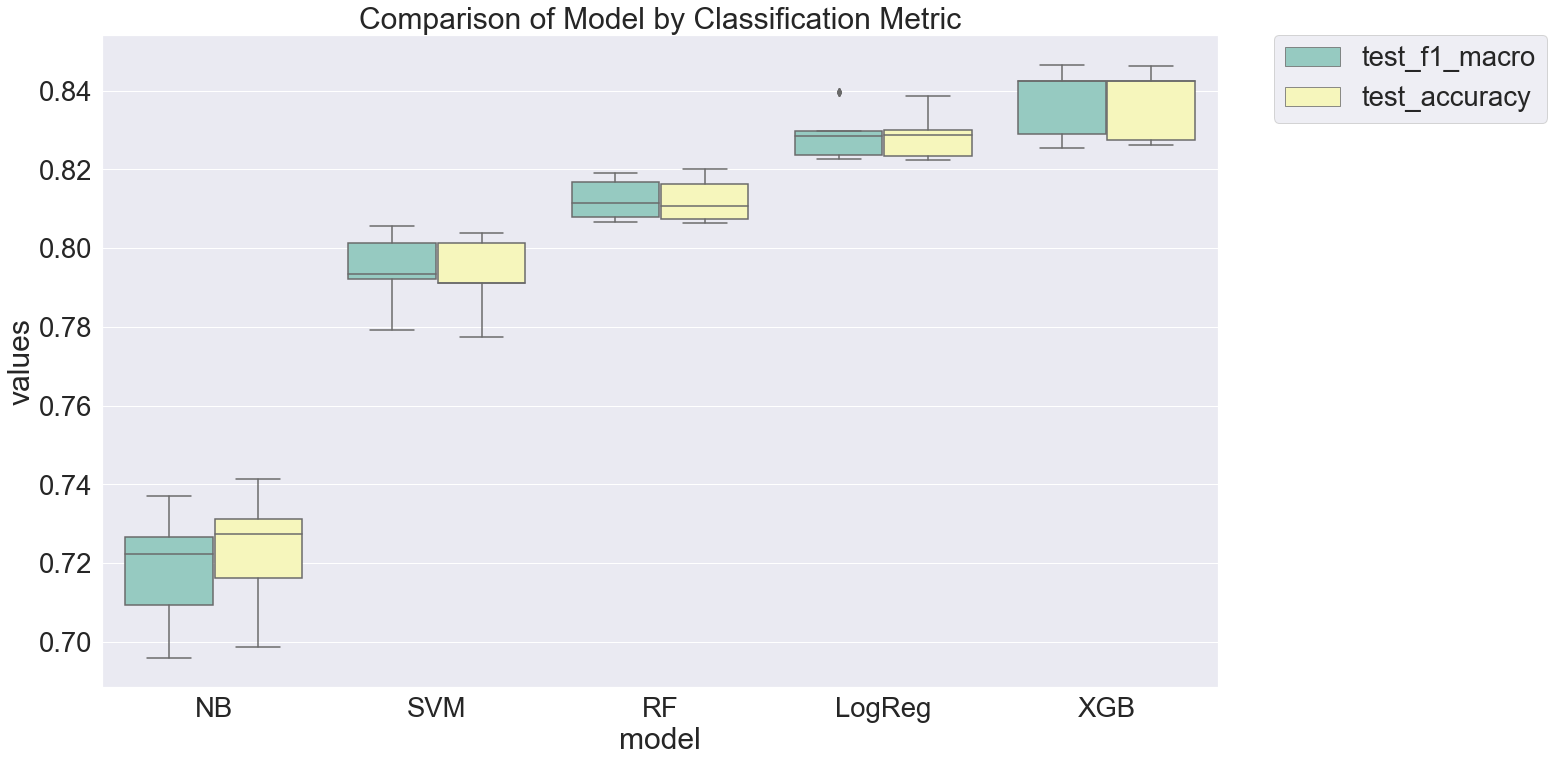

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

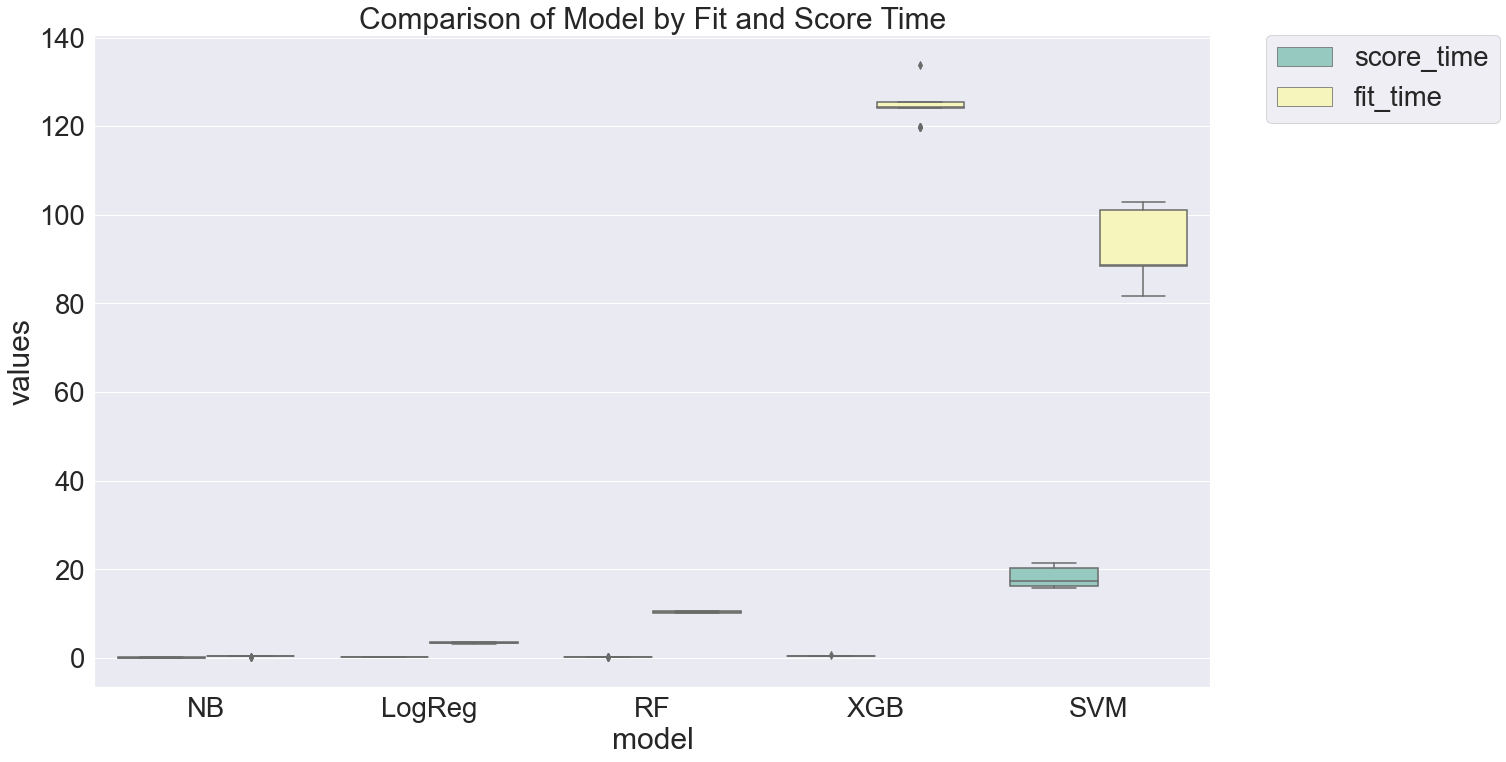

In [24]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [25]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.829333  0.005979      0.829533  0.006277
NB          0.723917  0.013272      0.719166  0.012936
RF          0.812167  0.005609      0.812368  0.005179
SVM         0.793292  0.008799      0.794552  0.008482
XGB         0.836417  0.008659      0.836501  0.008669

In [26]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time          
             mean       std        mean       std
model                                            
LogReg   0.130885  0.006621    3.477033  0.179588
NB       0.098566  0.017799    0.371685  0.033595
RF       0.193659  0.024507   10.354786  0.231071
SVM     17.870026  2.215124   92.028351  8.065416
XGB      0.481693  0.032751  124.074287  2.814847

### The following are 3 TF-IDF methods

#### TF-IDF Vectors as features

In [27]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(feature_df['cleaned_text'])
xtrain_tfidf =  tfidf_vect.transform(x_train["cleaned_text"])
xvalid_tfidf =  tfidf_vect.transform(x_test["cleaned_text"])

#create df for the vectors (both train and test)

xtrain_tfidf_vect_df = pd.DataFrame(xtrain_tfidf.toarray(), columns=tfidf_vect.get_feature_names(),index= x_train.index)
xvalid_tfidf_vect_df = pd.DataFrame(xvalid_tfidf.toarray(), columns=tfidf_vect.get_feature_names(),index= x_test.index)
#concat x train data (merge with previously created features)
x_train_tfidf_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_tfidf = pd.concat([x_train_tfidf_ready_for_concat, xtrain_tfidf_vect_df], axis=1)
#concat x test data (merge with previously created features)
x_test_tfidf_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_tfidf = pd.concat([x_test_tfidf_ready_for_concat, xvalid_tfidf_vect_df], axis=1)

In [28]:
# Model building for word level tf-idf


dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_tfidf, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_tfidf, y_train)
    y_pred = clf.predict(xvalid_tfidf)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final

LogReg
              precision    recall  f1-score   support

        Poor     0.9493    0.8086    0.8733       324
     Neutral     0.7728    0.9099    0.8358       344
        Good     0.8119    0.7801    0.7957       332

    accuracy                         0.8340      1000
   macro avg     0.8447    0.8329    0.8349      1000
weighted avg     0.8430    0.8340    0.8346      1000

RF
              precision    recall  f1-score   support

        Poor     0.9393    0.8117    0.8709       324
     Neutral     0.7574    0.8983    0.8218       344
        Good     0.8077    0.7590    0.7826       332

    accuracy                         0.8240      1000
   macro avg     0.8348    0.8230    0.8251      1000
weighted avg     0.8330    0.8240    0.8247      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9650    0.7654    0.8537       324
     Neutral     0.7458    0.9128    0.8209       344
        Good     0.7919    0.7681    0.7798       332

    ac

In [29]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,3.260670,0.090482,0.80500,0.805528,LogReg
1,2.718601,0.062666,0.82500,0.826481,LogReg
2,2.700856,0.070308,0.84250,0.842828,LogReg
3,2.850497,0.058204,0.81875,0.819512,LogReg
4,2.693868,0.070298,0.81500,0.816257,LogReg
5,7.317834,0.114207,0.78875,0.789036,RF
6,7.235698,0.093052,0.79125,0.792298,RF
7,7.091378,0.089832,0.81125,0.811533,RF
8,7.281315,0.093270,0.80625,0.807390,RF
9,7.048671,0.101064,0.80625,0.808295,RF


In [30]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

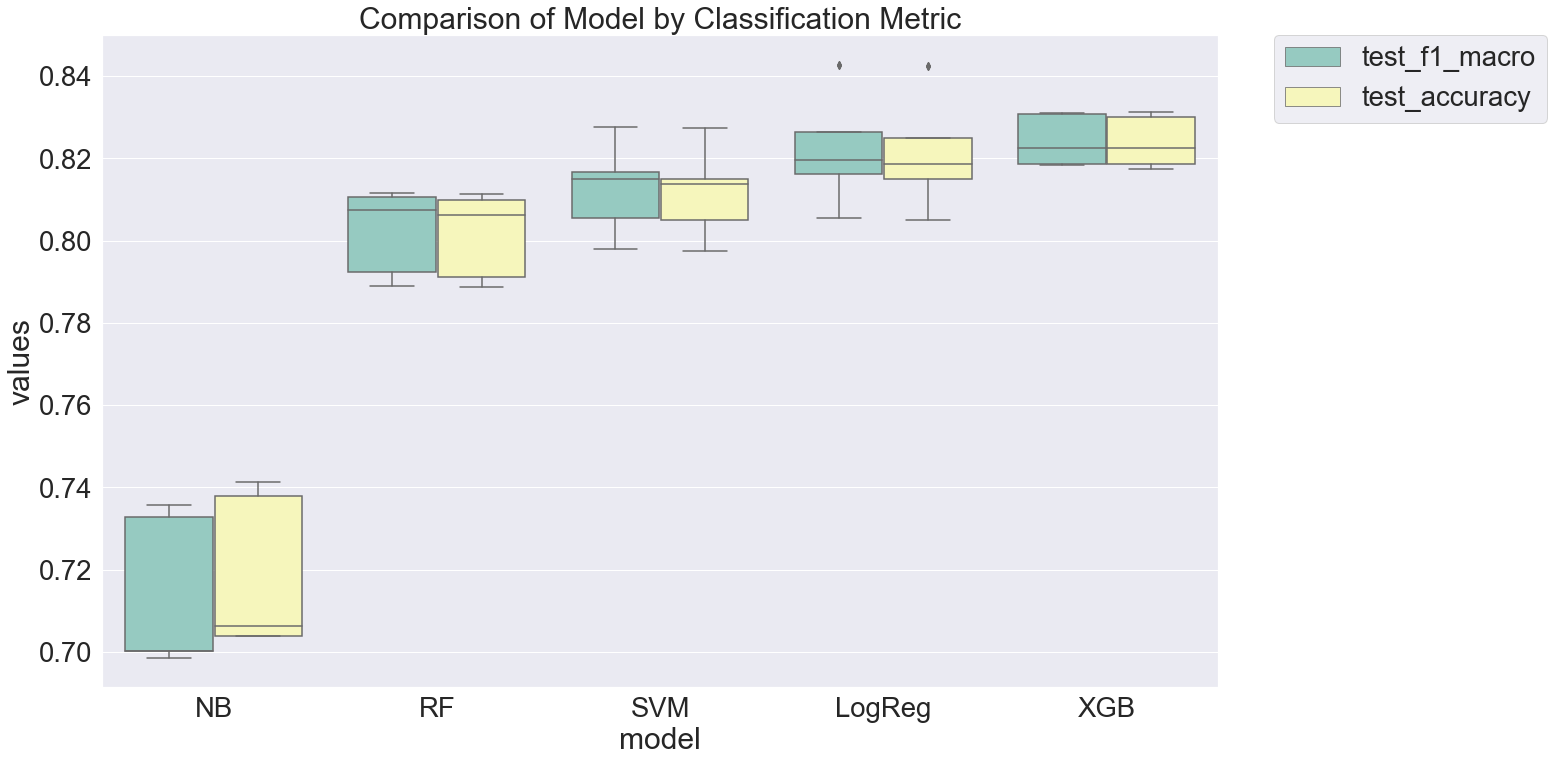

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

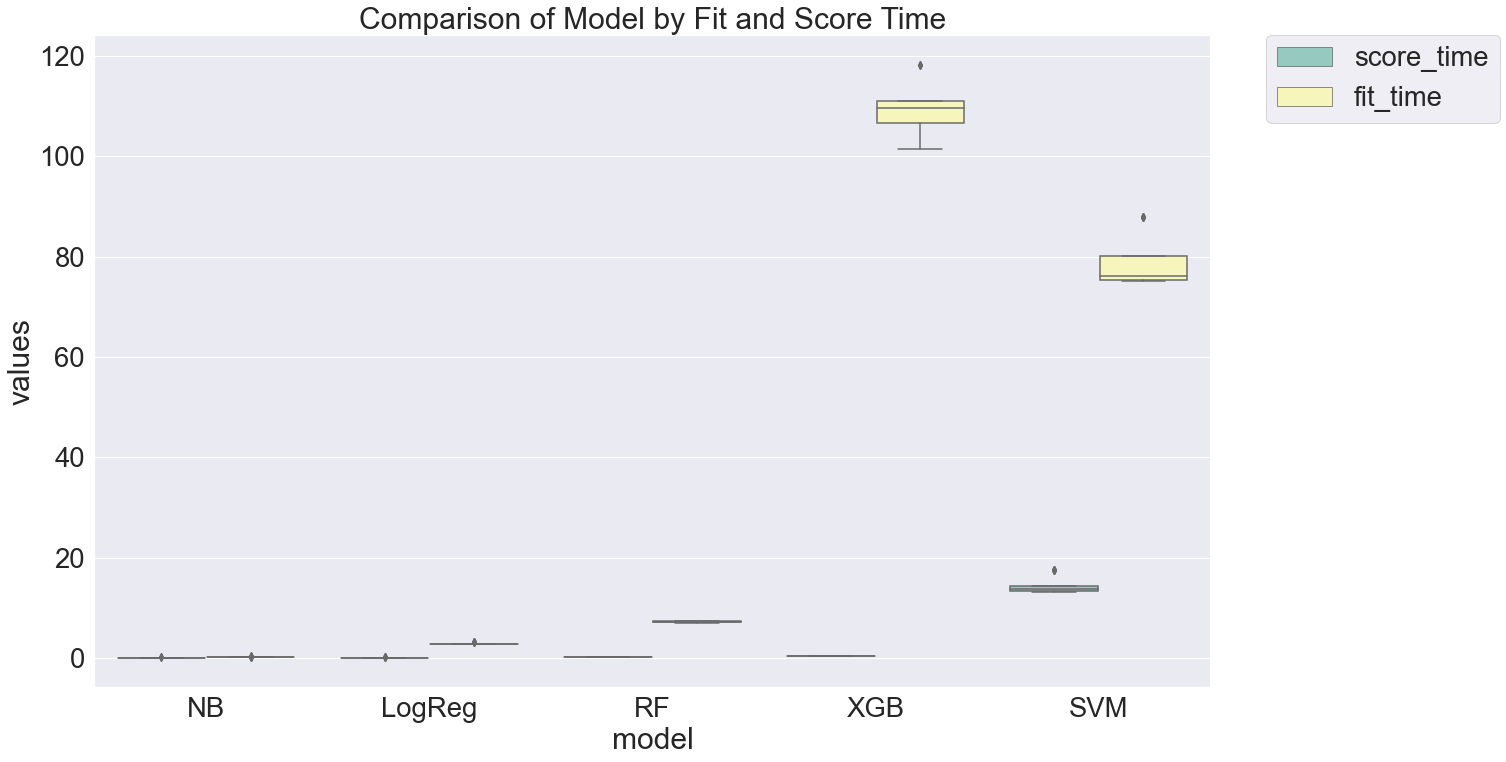

In [32]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [33]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.819042  0.010585      0.820037  0.010618
NB          0.719042  0.016866      0.714015  0.016826
RF          0.802167  0.009013      0.803041  0.009090
SVM         0.812583  0.010096      0.813388  0.010026
XGB         0.823750  0.005909      0.824121  0.005751

In [34]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time          
             mean       std        mean       std
model                                            
LogReg   0.070285  0.011206    2.840627  0.220434
NB       0.064102  0.011455    0.268675  0.013092
RF       0.096846  0.008602    7.198130  0.104152
SVM     14.555799  1.713442   79.313235  5.107162
XGB      0.399984  0.032495  108.874749  5.134343

#### ngram level tf-idf 

In [35]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(feature_df['cleaned_text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train["cleaned_text"])
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(x_test["cleaned_text"])


#create df for the vectors (both train and test)

xtrain_tfidf_ngram_vect_df = pd.DataFrame(xtrain_tfidf_ngram.toarray(), columns=tfidf_vect_ngram.get_feature_names(),index= x_train.index)
xvalid_tfidf_ngram_vect_df = pd.DataFrame(xvalid_tfidf_ngram.toarray(), columns=tfidf_vect_ngram.get_feature_names(),index= x_test.index)
#concat x train data (merge with previously created features)
x_train_tfidf_ngram_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_tfidf_ngram = pd.concat([x_train_tfidf_ngram_ready_for_concat, xtrain_tfidf_ngram_vect_df], axis=1)
#concat x test data (merge with previously created features)
x_test_tfidf_ngram_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_tfidf_ngram = pd.concat([x_test_tfidf_ngram_ready_for_concat, xvalid_tfidf_ngram_vect_df], axis=1)


In [36]:
# Model building for ngram level tf-idf


dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_tfidf_ngram, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_tfidf_ngram, y_train)
    y_pred = clf.predict(xvalid_tfidf_ngram)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.7623    0.5247    0.6216       324
     Neutral     0.5673    0.7965    0.6626       344
        Good     0.6190    0.5482    0.5815       332

    accuracy                         0.6260      1000
   macro avg     0.6496    0.6231    0.6219      1000
weighted avg     0.6477    0.6260    0.6224      1000

RF
              precision    recall  f1-score   support

        Poor     0.5885    0.4414    0.5044       324
     Neutral     0.4988    0.6105    0.5490       344
        Good     0.5000    0.5060    0.5030       332

    accuracy                         0.5210      1000
   macro avg     0.5291    0.5193    0.5188      1000
weighted avg     0.5283    0.5210    0.5193      1000

SVM
              precision    recall  f1-score   support

        Poor     0.6908    0.5586    0.6177       324
     Neutral     0.5840    0.6570    0.6183       344
        Good     0.5812    0.6145    0.5974       332

    ac

In [37]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,3.168243,0.114840,0.61625,0.610745,LogReg
1,2.910147,0.060198,0.61625,0.608655,LogReg
2,2.662300,0.090605,0.61250,0.604113,LogReg
3,3.182656,0.060218,0.61500,0.612014,LogReg
4,3.268873,0.062574,0.58000,0.575527,LogReg
5,11.556762,0.132480,0.51625,0.513226,RF
6,11.422789,0.124655,0.53000,0.526495,RF
7,11.111123,0.123066,0.53125,0.528639,RF
8,11.301492,0.131539,0.50250,0.499297,RF
9,11.159815,0.122233,0.51125,0.506582,RF


In [38]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

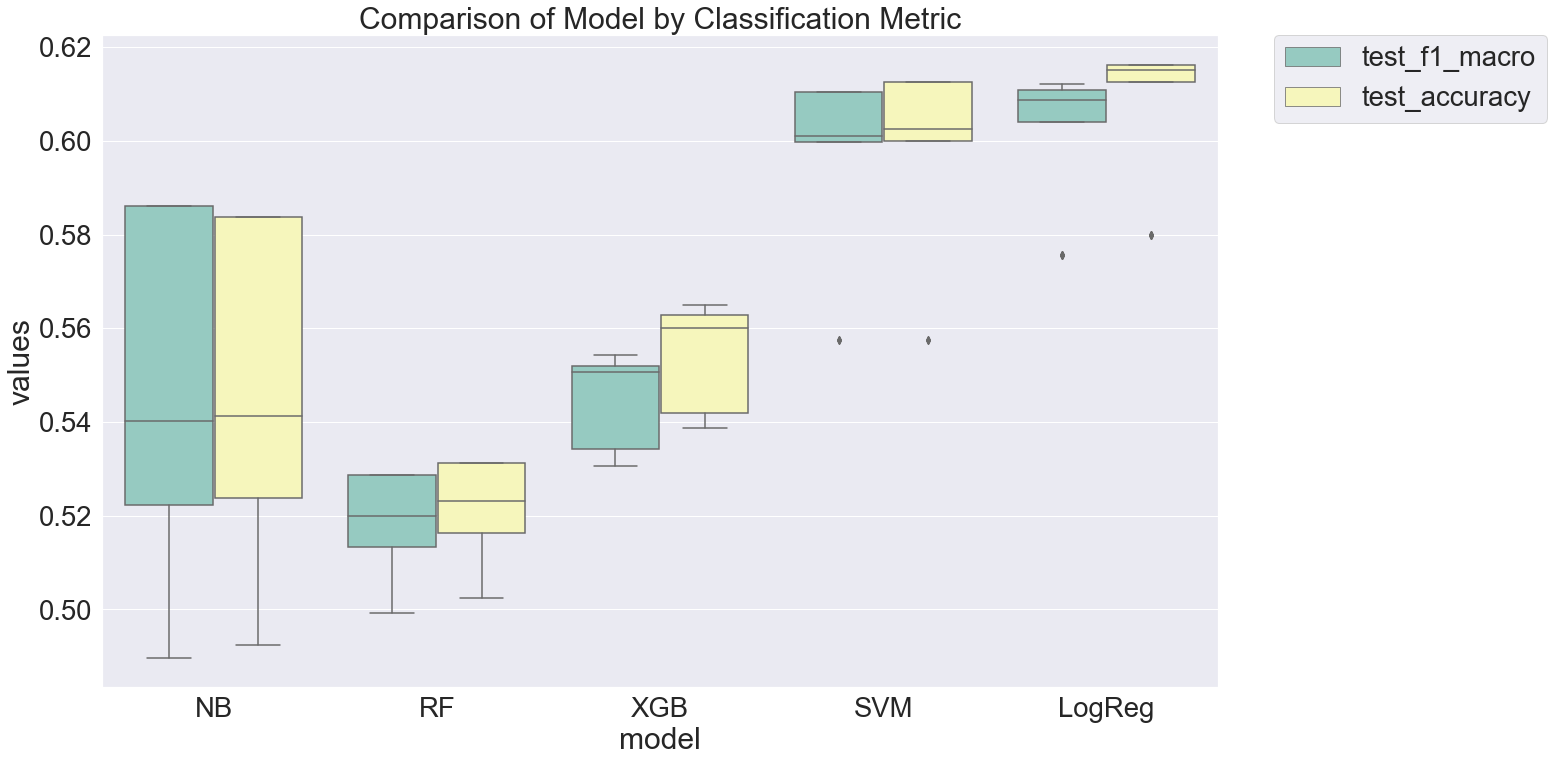

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

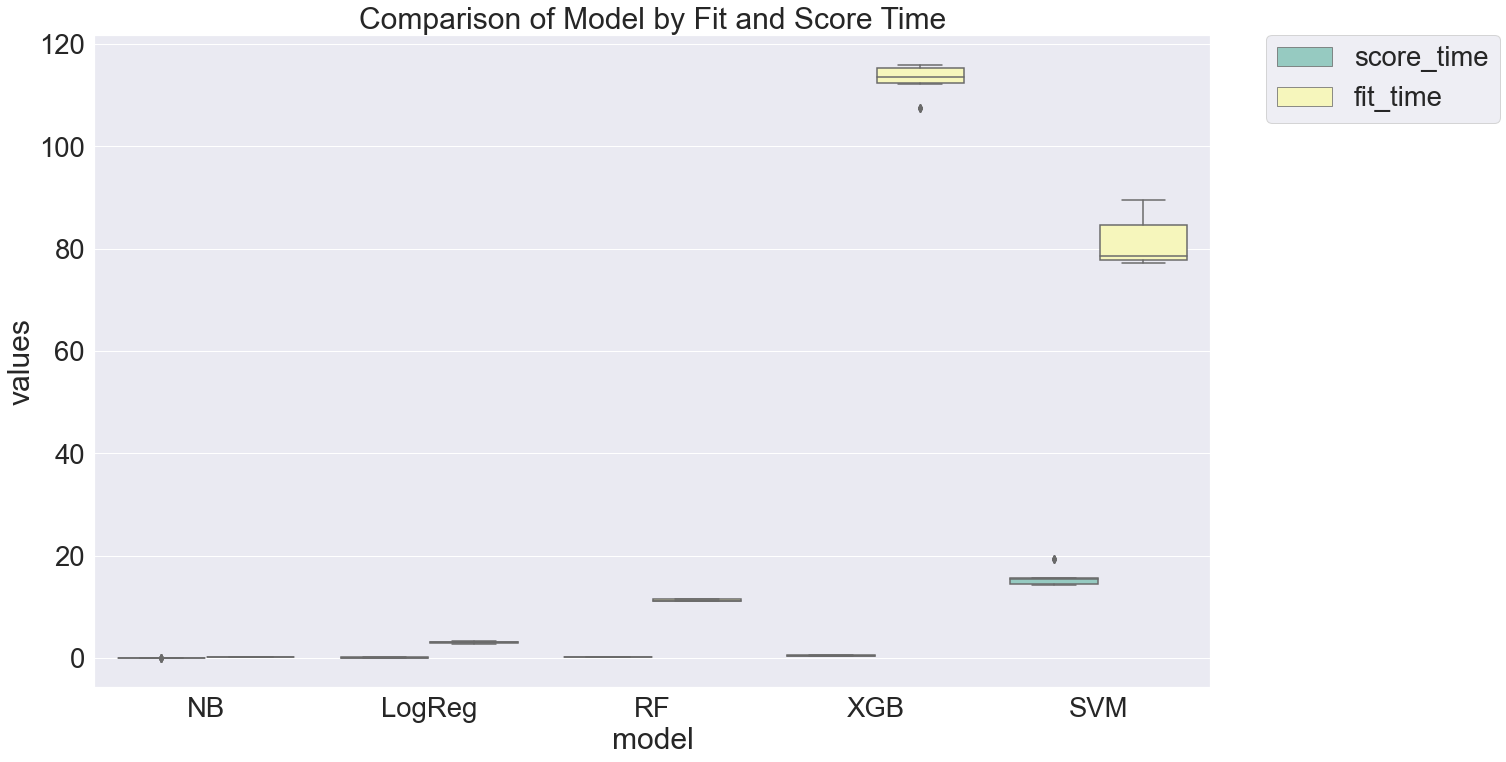

In [40]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [41]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.609333  0.013410      0.603536  0.013002
NB          0.542292  0.035029      0.541887  0.037012
RF          0.521625  0.010345      0.518511  0.010766
SVM         0.601333  0.015643      0.600070  0.015075
XGB         0.553667  0.010176      0.544800  0.009080

In [42]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time          
             mean       std        mean       std
model                                            
LogReg   0.078416  0.023190    3.043351  0.214164
NB       0.059845  0.006033    0.227018  0.040751
RF       0.126419  0.004530   11.276267  0.193253
SVM     15.814386  1.834911   81.953415  5.005861
XGB      0.476124  0.111225  112.809711  2.935516

#### characters level tf-idf

In [43]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(feature_df['cleaned_text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train["cleaned_text"]) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test["cleaned_text"])


#create df for the vectors (both train and test)

xtrain_tfidf_chars_vect_df = pd.DataFrame(xtrain_tfidf_ngram_chars.toarray(), columns=tfidf_vect_ngram_chars.get_feature_names(),index= x_train.index)
xvalid_tfidf_chars_vect_df = pd.DataFrame(xvalid_tfidf_ngram_chars.toarray(), columns=tfidf_vect_ngram_chars.get_feature_names(),index= x_test.index)
#concat x train data (merge with previously created features)
x_train_tfidf_ngram_chars_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_tfidf_ngram_chars = pd.concat([x_train_tfidf_ngram_chars_ready_for_concat, xtrain_tfidf_chars_vect_df], axis=1)
#concat x test data (merge with previously created features)
x_test_tfidf_ngram_chars_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_tfidf_ngram_chars = pd.concat([x_test_tfidf_ngram_chars_ready_for_concat, xvalid_tfidf_chars_vect_df], axis=1)


In [44]:
# Model building for char level tf-idf


dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_tfidf_ngram_chars, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_tfidf_ngram_chars, y_train)
    y_pred = clf.predict(xvalid_tfidf_ngram_chars)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.8355    0.7840    0.8089       324
     Neutral     0.7421    0.8198    0.7790       344
        Good     0.7373    0.7018    0.7191       332

    accuracy                         0.7690      1000
   macro avg     0.7717    0.7685    0.7690      1000
weighted avg     0.7708    0.7690    0.7688      1000

RF
              precision    recall  f1-score   support

        Poor     0.8157    0.7377    0.7747       324
     Neutral     0.7095    0.8023    0.7531       344
        Good     0.7013    0.6717    0.6862       332

    accuracy                         0.7380      1000
   macro avg     0.7422    0.7372    0.7380      1000
weighted avg     0.7412    0.7380    0.7379      1000

SVM
              precision    recall  f1-score   support

        Poor     0.8582    0.7469    0.7987       324
     Neutral     0.7280    0.8401    0.7800       344
        Good     0.7290    0.7048    0.7167       332

    ac

In [45]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,2.841441,0.070474,0.74875,0.749106,LogReg
1,3.120911,0.060328,0.76500,0.765452,LogReg
2,3.005014,0.066379,0.77875,0.778171,LogReg
3,2.735572,0.070374,0.73375,0.733136,LogReg
4,2.871290,0.080329,0.75375,0.754132,LogReg
5,4.672222,0.071778,0.74625,0.746720,RF
6,4.414025,0.071884,0.74250,0.742826,RF
7,4.410646,0.071657,0.75000,0.749204,RF
8,4.635041,0.072803,0.72250,0.722424,RF
9,4.560185,0.071624,0.72125,0.720937,RF


In [46]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

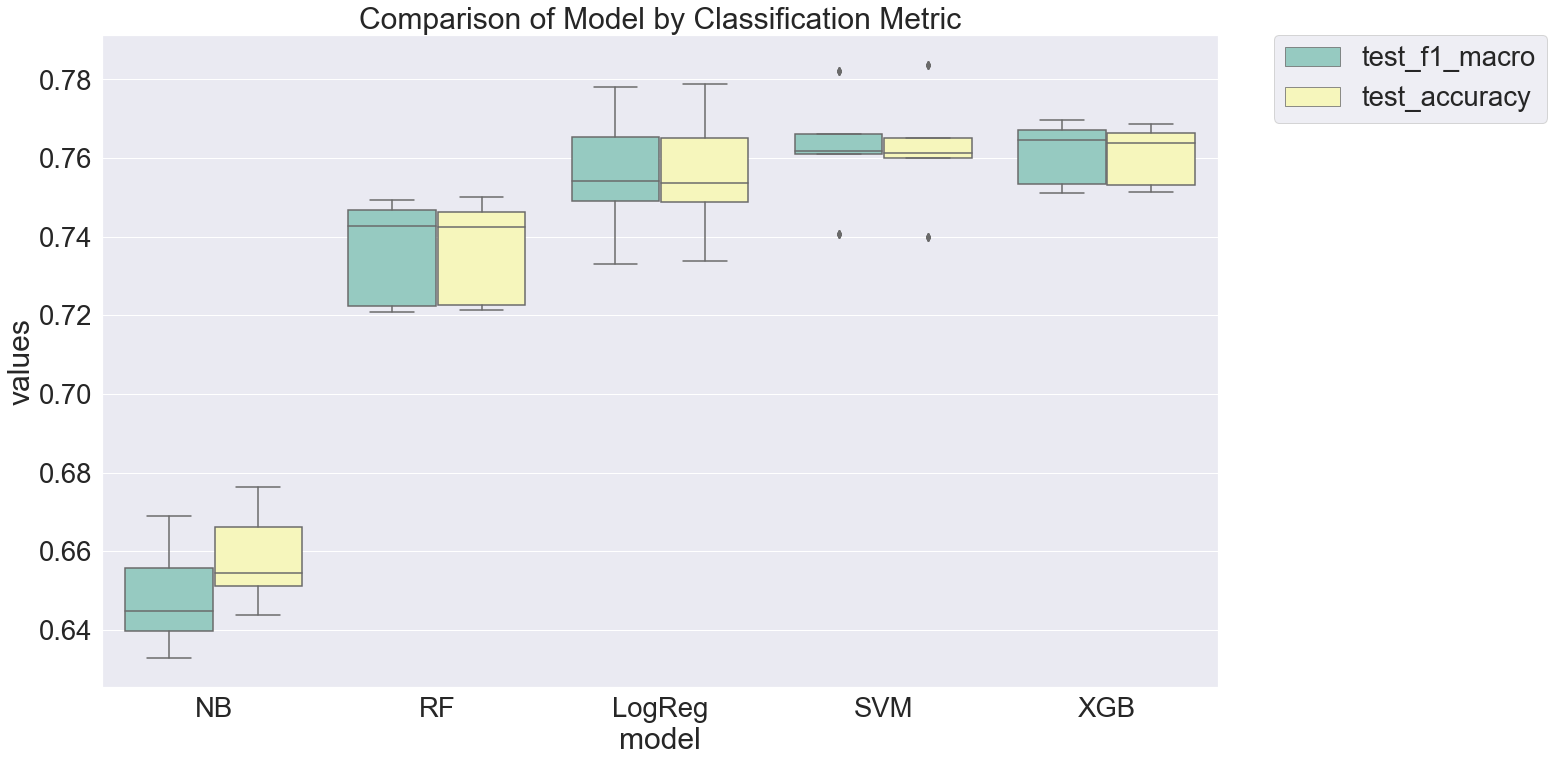

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

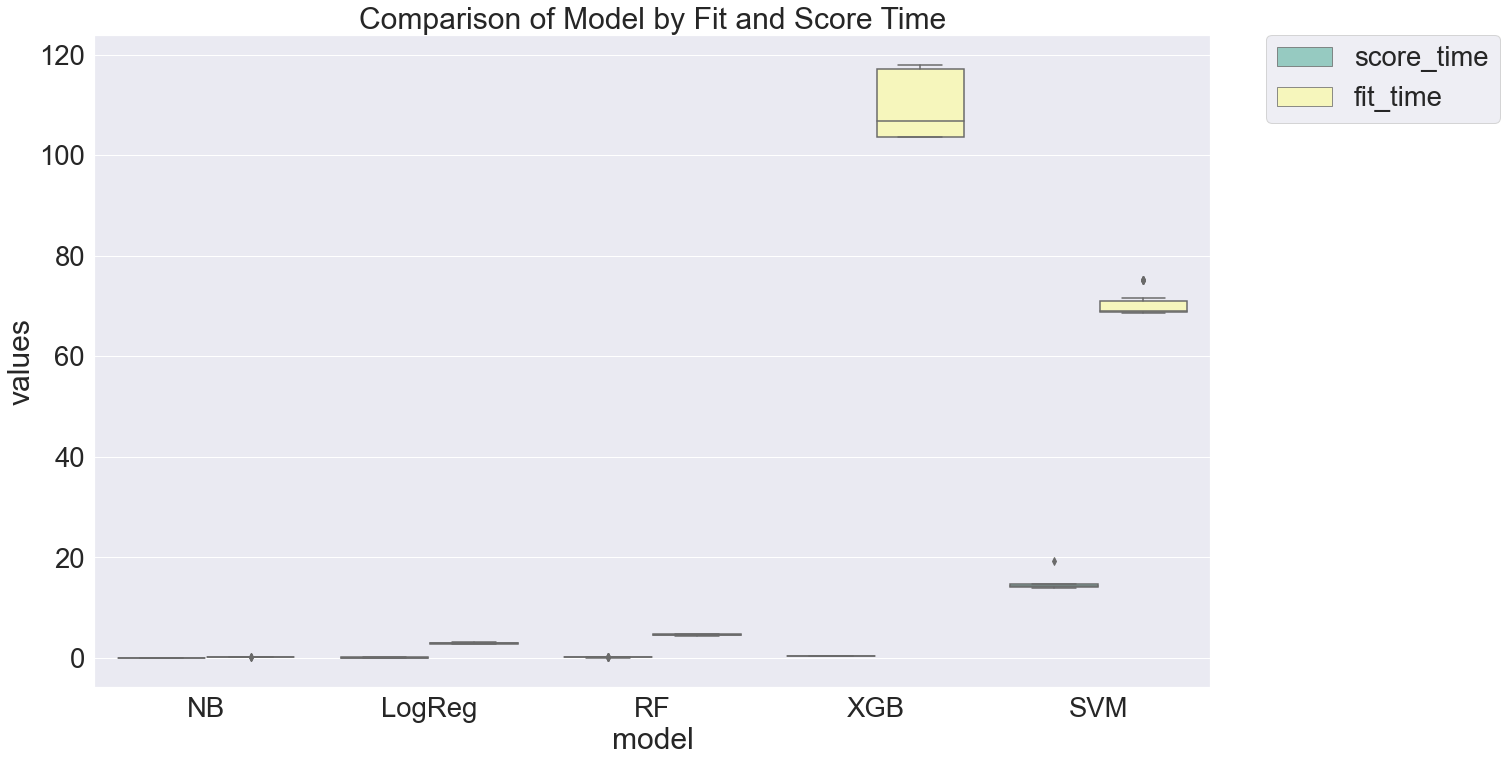

In [48]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [49]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.758833  0.014031      0.758900  0.013903
NB          0.657875  0.012208      0.648292  0.013688
RF          0.735958  0.012640      0.735919  0.012727
SVM         0.762125  0.015306      0.762467  0.014584
XGB         0.760667  0.006422      0.761321  0.006843

In [50]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time          
             mean       std        mean       std
model                                            
LogReg   0.070107  0.007211    2.932875  0.123994
NB       0.054944  0.008324    0.248933  0.019576
RF       0.071977  0.000471    4.571723  0.105716
SVM     14.456907  0.959755   70.434413  2.741120
XGB      0.396257  0.033433  109.010953  6.133808